In [198]:
import pandas as pd

# correlation
from string import ascii_letters
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# for preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# for prediciting
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


# for assessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve

In [199]:
teams_internal = {'CHI':'CHB','GSW':'GSW','MIA':'MIH','BOS':'BOC'} ### 'LAL':'LAL',

df = pd.read_excel('C:/Users/Marc/Dropbox/06_ESCP/01_Uni/06_MA Thesis/04_Code/02_Output/01_NBA Scheudle & Stats/LAL/03_stats_merged with opponent/LAL_hist_data_overview.xlsx')

for teams in teams_internal:
    df_add = pd.read_excel('C:/Users/Marc/Dropbox/06_ESCP/01_Uni/06_MA Thesis/04_Code/02_Output/01_NBA Scheudle & Stats/'+ teams_internal[teams] + '/03_stats_merged with opponent/'+ teams_internal[teams] + '_hist_data_overview.xlsx')
    df = df.append(df_add)

In [200]:
df_comp = df.iloc[300:,:7]

In [201]:
# set number of game as index
df = df.set_index(['G'])

In [202]:
# y (dependent) in binary
Y = df['W/L'].map(dict(W = 1, L = 0))
df['y'] = y
df = df.drop(columns = ['W/L'])


In [203]:
# prepare dataset for prediction
# map Home and Away to binary
df['Home / Away'] = df['Home / Away'].map(dict(Home = 1, Away = 0))

# Remove home team as is always the same
df = df.drop(columns = ['Home Team'])

# remove date, as we are not predicition over mutliple seasons. Time of year wont help prediciting
df = df.drop(columns = ['Date'])

# remove opp as the number should reflect what the categories say -> dimensionality reduction
df = df.drop(columns = ['Opp'])

# Correlation inspection

<AxesSubplot:>

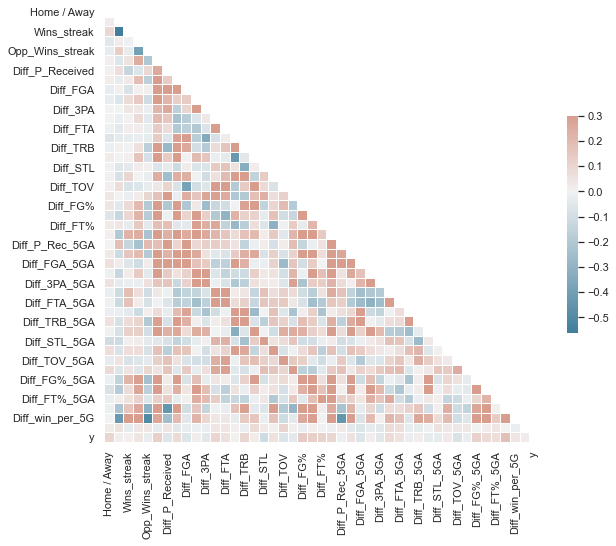

In [204]:
# Correlation Heatmap
# Used instead of Variance Inflation Factor, as the dataset contains averages over past 5 games or just of the current seasonon until the game
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [205]:
# According to Chen and Rothschild, 2010, --> 0.9 = multicolinearity is certain
# Filtering out the columns that have a correlation of more than 0.9
abs_corr = corr.abs()
abs_corr_filtered = abs_corr[abs_corr >= 0.9]
abs_corr_filtered.loc[:, (abs_corr_filtered.sum() >= 2.8)].columns

# First all correlations made absolute, then filtered for above or equal to 0.9, and then names extraced that are more than 2.8 (self correlated, lower and upper triangle)

### None of the features have a correlation of higer than 0.9, hence no multicolinearity to be taken care of


Index([], dtype='object')

Interpretation Heatmap:
- some features are highly negative correlated - no problem
- legend only goes to 0.2 positve correlation - good
- no feature is deleted

# Scaling

General inspection

[Text(0, 0, 'Losses_streak'),
 Text(1, 0, 'Wins_streak'),
 Text(2, 0, 'Opp_Losses_streak'),
 Text(3, 0, 'Opp_Wins_streak'),
 Text(4, 0, 'Diff_P_Team'),
 Text(5, 0, 'Diff_P_Received'),
 Text(6, 0, 'Diff_FG'),
 Text(7, 0, 'Diff_FGA'),
 Text(8, 0, 'Diff_3P'),
 Text(9, 0, 'Diff_3PA'),
 Text(10, 0, 'Diff_FT'),
 Text(11, 0, 'Diff_FTA'),
 Text(12, 0, 'Diff_ORB'),
 Text(13, 0, 'Diff_TRB'),
 Text(14, 0, 'Diff_AST'),
 Text(15, 0, 'Diff_STL'),
 Text(16, 0, 'Diff_BLK'),
 Text(17, 0, 'Diff_TOV'),
 Text(18, 0, 'Diff_PF'),
 Text(19, 0, 'Diff_FG%'),
 Text(20, 0, 'Diff_3P%'),
 Text(21, 0, 'Diff_FT%'),
 Text(22, 0, 'Diff_P_Team_5GA'),
 Text(23, 0, 'Diff_P_Rec_5GA'),
 Text(24, 0, 'Diff_FG_5GA'),
 Text(25, 0, 'Diff_FGA_5GA'),
 Text(26, 0, 'Diff_3P_5GA'),
 Text(27, 0, 'Diff_3PA_5GA'),
 Text(28, 0, 'Diff_FT_5GA'),
 Text(29, 0, 'Diff_FTA_5GA'),
 Text(30, 0, 'Diff_ORB_5GA'),
 Text(31, 0, 'Diff_TRB_5GA'),
 Text(32, 0, 'Diff_AST_5GA'),
 Text(33, 0, 'Diff_STL_5GA'),
 Text(34, 0, 'Diff_BLK_5GA'),
 Text(35, 0, 'Di

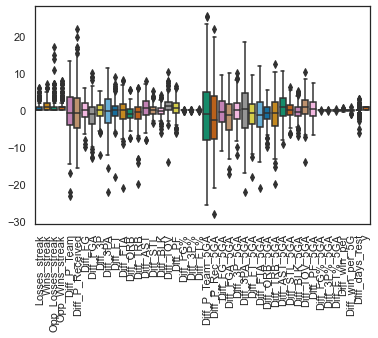

In [207]:
# boxpltos
boxp = sns.boxplot(data=df.iloc[:,1:],palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)

# Hence high devation in difference in Min-Max, Standard Deviation

In [208]:
# check std, min, max etc.
df.describe()

,Home / Away,Losses_streak,Wins_streak,Opp_Losses_streak,Opp_Wins_streak,Diff_P_Team,Diff_P_Received,Diff_FG,Diff_FGA,Diff_3P,...,Diff_BLK_5GA,Diff_TOV_5GA,Diff_PF_5GA,Diff_FG%_5GA,Diff_3P%_5GA,Diff_FT%_5GA,Diff_win_per,Diff_win_per_5G,Diff_days_rest,y
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,...,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.498592,0.898592,1.047887,1.135211,1.028169,-0.415241,-0.545678,-0.096817,-1.385748,-0.078102,...,-0.301080,0.933286,0.435728,0.003733,-0.002672,-0.002662,0.035211,0.016995,0.014085,0.526761
std,0.500704,1.221684,1.373874,2.020733,1.480302,5.766356,6.193387,2.547142,3.576626,2.230289,...,1.849562,2.989068,2.709320,0.037281,0.054521,0.069144,0.172088,0.341759,0.937194,0.499988
min,0.000000,0.000000,0.000000,0.000000,0.000000,-23.250000,-15.666667,-10.000000,-12.750000,-12.000000,...,-7.000000,-14.000000,-6.600000,-0.137374,-0.176334,-0.181159,-0.369281,-1.000000,-6.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-4.032517,-4.625119,-1.651649,-3.551732,-1.446242,...,-1.400000,-1.000000,-1.400000,-0.021418,-0.039238,-0.045505,-0.086221,-0.200000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,-0.623846,-0.710145,-0.001783,-0.941958,0.023810,...,-0.400000,1.000000,0.400000,0.002701,0.000278,-0.010571,0.023810,0.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,1.000000,3.502964,3.281967,1.896296,0.922389,1.375855,...,0.800000,2.816667,2.200000,0.030834,0.034983,0.043363,0.153998,0.200000,0.000000,1.000000
max,1.000000,6.000000,7.000000,17.000000,8.000000,13.476190,22.000000,6.000000,10.000000,5.149471,...,5.200000,10.500000,7.400000,0.124929,0.165206,0.342105,0.600000,1.000000,3.000000,1.000000


In [209]:
# General prep
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.3, random_state=42,stratify = y, shuffle = True)


In [210]:
# Save feature names to add back once scaled (feature titles lost in process)
columns = df.columns

Standard Scaler

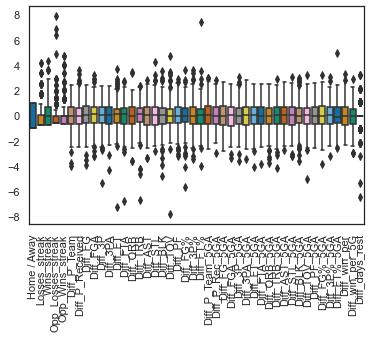

In [211]:
# Standard Scaler
scaler_ss = StandardScaler()
df_ss = pd.DataFrame(scaler_ss.fit_transform(df))
df_ss.columns = columns
df_ss = df_ss.drop(columns = ['y'])

# boxpltos after standard scaler
boxp = sns.boxplot(data=df_ss ,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)


#Train test split for Standard Scaler
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(df_ss, Y, test_size=0.3, random_state=42,stratify = y, shuffle = True)

Min Max Scaled

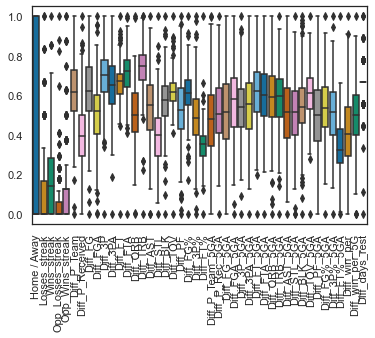

In [212]:
# Min max Scaled
columns = df.columns
scaler_mm = MinMaxScaler()
df_min_max = pd.DataFrame(scaler_mm.fit_transform(df))
df_min_max.columns = columns
df_min_max = df_min_max.drop(columns = ['y'])

# boxpltos after Min-Max scaled
boxp = sns.boxplot(data=df_min_max,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)


X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(df_min_max, Y, test_size=0.3, random_state=42,stratify = y, shuffle = True)

Robust Scaler Scaled

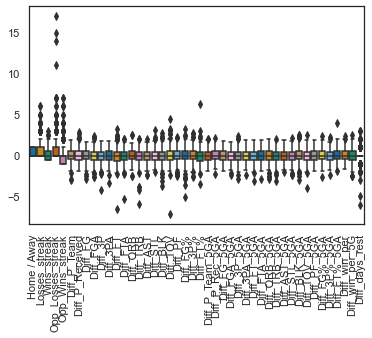

In [213]:
# Robust Scaler
columns = df.columns
scaler_rs = RobustScaler()
df_rs = pd.DataFrame(scaler_rs.fit_transform(df))
df_rs.columns = columns
df_rs = df_rs.drop(columns = ['y'])

# boxpltos after Robbust scaled
boxp = sns.boxplot(data=df_rs,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)


X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(df_rs, Y, test_size=0.3, random_state=42,stratify = y, shuffle = True)

Z-score approach

As with standard scaling methods, outliers remain. New approach of Z-Score
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [214]:
z = np.abs(stats.zscore(df))
# to delete outliers
df_z_score = df[(z < 3).all(axis=1)]
# reducing the outliers

y_z_apporach = df_z_score.y

Z-Score x Standard Scaler

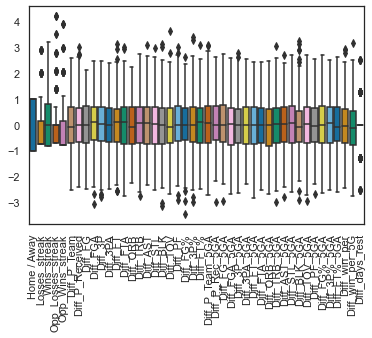

In [215]:
### Z-Standard Scaler
scaler_zs = StandardScaler()
df_zs_num = pd.DataFrame(scaler_zs.fit_transform(df_z_score))
df_zs_num.columns = columns
df_zs_num = df_zs_num.drop(columns = ['y'])

# ZS_boxpltos
boxp_zs = sns.boxplot(data=df_zs_num,palette="colorblind")
boxp_zs.set_xticklabels(boxp_zs.get_xticklabels(),rotation=90)

### Usally take z = 3 as 3 std should cover around 99% of the data should be covered. When looked at the boxplots, there are however still outliers. Hence, approach could either adjust z further, or try predicition without customer info 2

# train test for Z score Standard
X_train_zss, X_test_zss, y_train_zss, y_test_zss = train_test_split(df_zs_num, y_z_apporach, test_size=0.3, random_state=42, shuffle = True)

Z-Score x MinMax Scaler

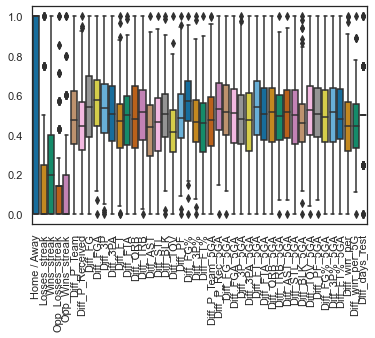

In [216]:
### Z-MinMax Scaler
scaler_zmms = MinMaxScaler()
df_zmms_num = pd.DataFrame(scaler_zmms.fit_transform(df_z_score))
df_zmms_num.columns = columns
df_zmms_num = df_zmms_num.drop(columns = ['y'])

# ZM_boxpltos
boxp_zmms = sns.boxplot(data=df_zmms_num,palette="colorblind")
boxp_zmms.set_xticklabels(boxp_zmms.get_xticklabels(),rotation=90)

### Usally take z = 3 as 3 std should cover around 99% of the data should be covered. When looked at the boxplots, there are however still outliers. Hence, approach could either adjust z further, or try predicition without customer info 2

# train test for Z score MinMax
X_train_zmms, X_test_zmms, y_train_zmms, y_test_zmms = train_test_split(df_zmms_num, y_z_apporach, test_size=0.3, random_state=42, shuffle = True)

Z-Score x Robust

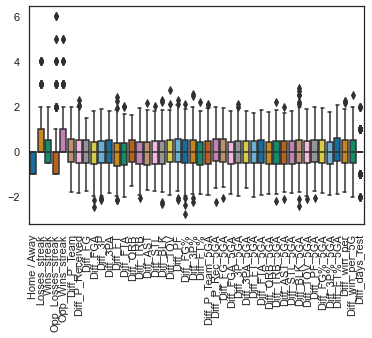

In [217]:
### Z-Robust Scaler
columns = df.columns
scaler_zrs = RobustScaler()
df_zrs_num = pd.DataFrame(scaler_zrs.fit_transform(df_z_score))
df_zrs_num.columns = columns
df_zrs_num = df_zrs_num.drop(columns = ['y'])

# ZM_boxpltos
boxp_zrs = sns.boxplot(data=df_zrs_num,palette="colorblind")
boxp_zrs.set_xticklabels(boxp_zrs.get_xticklabels(),rotation=90)

### Usally take z = 3 as 3 std should cover around 99% of the data should be covered. When looked at the boxplots, there are however still outliers. Hence, approach could either adjust z further, or try predicition without customer info 2

# train test for Z score MinMax
X_train_zrs, X_test_zrs, y_train_zrs, y_test_zrs = train_test_split(df_zrs_num, y_z_apporach, test_size=0.3, random_state=42, shuffle = True)

# Classifiers Win / Lose

In [218]:
overview_train = pd.DataFrame(columns = ['algorithm','not_scaled', 'standard', 'minmax', 'robust','z_standard', 'z_minmax', 'z_robust' ])
overview_test = pd.DataFrame(columns = ['algorithm','not_scaled', 'standard', 'minmax', 'robust','z_standard', 'z_minmax', 'z_robust' ])

# Logisitc Regression

accuarcy score not scaled:   0.5046728971962616


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


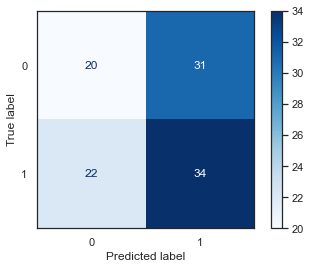

In [219]:
lr = LogisticRegression()

#Regular
X_train = X_train.drop(columns = ['y'])
X_test = X_test.drop(columns = ['y'])
lr_model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_lr =accuracy_score(y_pred, y_test)
print('accuarcy score not scaled:   ' + str(accuracy_score(y_pred, y_test)))
plot_confusion_matrix(lr_model, X_test, y_test, cmap=plt.cm.Blues)


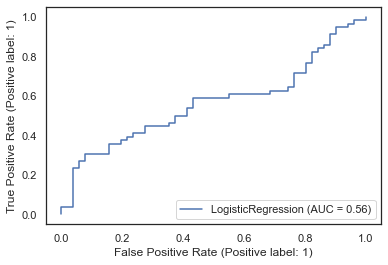

In [220]:
lr_disp = plot_roc_curve(lr, X_test, y_test)

In [221]:
overview_train['not_scaled'] = [lr.score(X_train, y_train)]
overview_test['not_scaled'] = [lr.score(X_test, y_test)]

In [ ]:
#Name 1st Row
overview_train['algorithm'] = ['logreg']
overview_test['algorithm'] = ['logreg']

#Enlarging the dataset so accuracy values later, can simply replace the NaN
overview_train = overview_train.append([0,0,0,0,0])
overview_test = overview_test.append([0,0,0,0,0])

#Rename 2nd row to XGboost_regular
overview_train['algorithm'].iloc[1] = 'xgboost'
overview_test['algorithm'].iloc[1] = 'xgboost'

#Rename 3d row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[2] = 'H_xgboost'
overview_test['algorithm'].iloc[2] = 'H-xgboost'

#Rename 4th row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[3] = 'rf'
overview_test['algorithm'].iloc[3] = 'rf'

#Rename 5th row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[4] = 'H_rf'
overview_test['algorithm'].iloc[4] = 'H_rf'

#Rename 6th row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[5] = 'gaussian'
overview_test['algorithm'].iloc[5] = 'gaussian'

accuarcy score with MinMax scaled:   0.5046728971962616


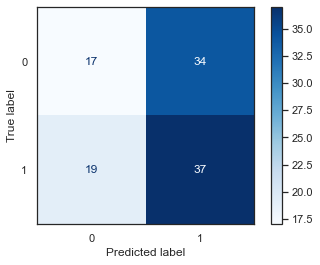

In [222]:
#MinMax Scaled
lr_model_mm = lr.fit(X_train_mm, y_train_mm)
y_pred_mm = lr.predict(X_test_mm)
accuracy_lr_mm =accuracy_score(y_pred_mm, y_test_mm)
print('accuarcy score with MinMax scaled:   ' + str(accuracy_score(y_pred_mm, y_test_mm)))
plot_confusion_matrix(lr_model_mm, X_test_mm, y_test_mm, cmap=plt.cm.Blues)

overview_train['minmax'].iloc[0] = lr_model_mm.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[0] = lr_model_mm.score(X_test_mm, y_test_mm)

accuarcy score with Standard scaled:   0.4953271028037383


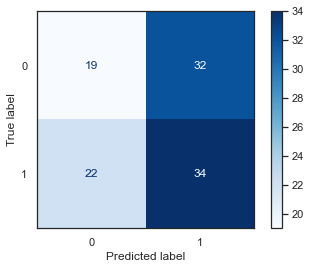

In [223]:
#Standard Scaled
lr_model_ss = lr.fit(X_train_ss, y_train_ss)
y_pred_ss = lr.predict(X_test_ss)
accuracy_lr_ss =accuracy_score(y_pred_ss, y_test_ss)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_ss, y_test_ss)))
plot_confusion_matrix(lr_model_ss, X_test_ss, y_test_ss, cmap=plt.cm.Blues)

overview_train['standard'].iloc[0] = lr_model_ss.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[0] = lr_model_ss.score(X_test_ss, y_test_ss)

accuarcy score with Standard scaled:   0.4766355140186916


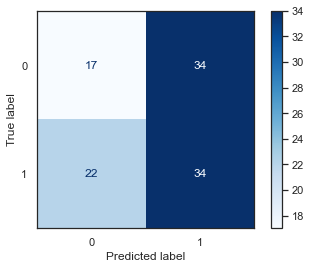

In [224]:
#Robust Scaled
lr_model_rs = lr.fit(X_train_rs, y_train_rs)
y_pred_rs = lr.predict(X_test_rs)
accuracy_lr_rs =accuracy_score(y_pred_rs, y_test_rs)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_rs, y_test_rs)))
plot_confusion_matrix(lr_model_rs, X_test_rs, y_test_rs, cmap=plt.cm.Blues)

overview_train['robust'].iloc[0] = lr_model_rs.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[0] = lr_model_rs.score(X_test_rs, y_test_rs)

Z Scaled logreg

accuarcy score with MinMax scaled:   0.6179775280898876


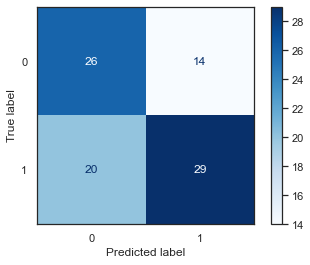

In [225]:
#MinMax Scaled
lr_model_zmms = lr.fit(X_train_zmms, y_train_zmms)
y_pred_zmms = lr.predict(X_test_zmms)
accuracy_lr_zmms =accuracy_score(y_pred_zmms, y_test_zmms)
print('accuarcy score with MinMax scaled:   ' + str(accuracy_score(y_pred_zmms, y_test_zmms)))
plot_confusion_matrix(lr_model_zmms, X_test_zmms, y_test_zmms, cmap=plt.cm.Blues)

overview_train['z_minmax'].iloc[0] = lr_model_zmms.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[0] = lr_model_zmms.score(X_test_zmms, y_test_zmms)

accuarcy score with Standard scaled:   0.6067415730337079


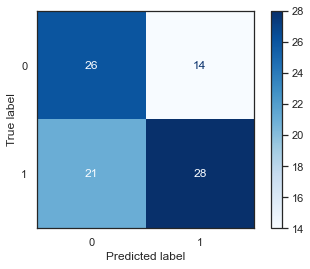

In [226]:
#Standard Scaled
lr_model_zss = lr.fit(X_train_zss, y_train_zss)
y_pred_zss = lr.predict(X_test_zss)
accuracy_lr_zss =accuracy_score(y_pred_zss, y_test_zss)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_zss, y_test_zss)))
plot_confusion_matrix(lr_model_zss, X_test_zss, y_test_zss, cmap=plt.cm.Blues)

overview_train['z_standard'].iloc[0] = lr_model_zss.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[0] = lr_model_zss.score(X_test_zss, y_test_zss)

accuarcy score with Standard scaled:   0.6179775280898876


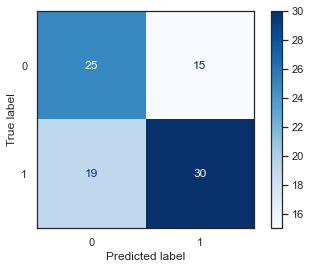

In [227]:
#Robust Scaled
lr_model_zrs = lr.fit(X_train_zrs, y_train_zrs)
y_pred_zrs = lr.predict(X_test_zrs)
accuracy_lr_zrs =accuracy_score(y_pred_zrs, y_test_zrs)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_zrs, y_test_zrs)))
plot_confusion_matrix(lr_model_zrs, X_test_zrs, y_test_zrs, cmap=plt.cm.Blues)

overview_train['z_robust'].iloc[0] = lr_model_zrs.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[0] = lr_model_zrs.score(X_test_zrs, y_test_zrs)

In [228]:
overview_train

,algorithm,not_scaled,standard,minmax,robust,z_standard,z_minmax,z_robust
0,logreg,0.677419,0.66129,0.629032,0.665323,0.690821,0.647343,0.681159


In [229]:
overview_test

,algorithm,not_scaled,standard,minmax,robust,z_standard,z_minmax,z_robust
0,logreg,0.504673,0.495327,0.504673,0.476636,0.606742,0.617978,0.617978


# XGBoost

In [230]:
# no Scaling
model_xg = XGBClassifier(use_label_encoder=False)
model_xg.fit(X_train, y_train)

y_pred_xg = model_xg.predict(X_test)
accuracy_xg = accuracy_score(y_test, y_pred_xg)


[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [232]:
overview_train['not_scaled'].iloc[1] = model_xg.score(X_train, y_train)
overview_test['not_scaled'].iloc[1] = model_xg.score(X_test, y_test)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [233]:
# MinMax
model_xg_mm = XGBClassifier(use_label_encoder=False)
model_xg_mm.fit(X_train_mm, y_train_mm)

y_pred_xg_mm = model_xg_mm.predict(X_test_mm)
accuracy_xg_mm = accuracy_score(y_test_mm, y_pred_xg_mm)

[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [234]:
overview_train['minmax'].iloc[1] = model_xg_mm.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[1] = model_xg_mm.score(X_test_mm, y_test_mm)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [235]:
# Standard Scaled
model_xg_ss = XGBClassifier(use_label_encoder=False)
model_xg_ss.fit(X_train_ss, y_train_ss)

y_pred_xg_ss = model_xg_ss.predict(X_test_ss)
accuracy_xg_ss = accuracy_score(y_test_ss, y_pred_xg_ss)

overview_train['standard'].iloc[1] = model_xg_ss.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[1] = model_xg_ss.score(X_test_ss, y_test_ss)

[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [236]:
# robust Scaled
model_xg_rs = XGBClassifier(use_label_encoder=False)
model_xg_rs.fit(X_train_rs, y_train_rs)

y_pred_xg_rs = model_xg_rs.predict(X_test_rs)
accuracy_xg_rs = accuracy_score(y_test_rs, y_pred_xg_rs)

overview_train['robust'].iloc[1] = model_xg_rs.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[1] = model_xg_rs.score(X_test_rs, y_test_rs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGboost - z value Outlier reduction

In [237]:
# Z_MinMax
model_xg_zmms = XGBClassifier(use_label_encoder=False)
model_xg_zmms.fit(X_train_zmms, y_train_zmms)

y_pred_xg_zmms = model_xg_zmms.predict(X_test_zmms)
accuracy_xg_zmms = accuracy_score(y_test_zmms, y_pred_xg_zmms)


overview_train['z_minmax'].iloc[1] = model_xg_zmms.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[1] = model_xg_zmms.score(X_test_zmms, y_test_zmms)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [238]:
# z_Standard Scaled
model_xg_zss = XGBClassifier(use_label_encoder=False)
model_xg_zss.fit(X_train_zss, y_train_zss)

y_pred_xg_zss = model_xg_zss.predict(X_test_zss)
accuracy_xg_zss = accuracy_score(y_test_zss, y_pred_xg_zss)

overview_train['z_standard'].iloc[1] = model_xg_zss.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[1] = model_xg_zss.score(X_test_zss, y_test_zss)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [239]:
# robust Scaled
model_xg_zrs = XGBClassifier(use_label_encoder=False)
model_xg_zrs.fit(X_train_zrs, y_train_zrs)

y_pred_xg_zrs = model_xg_zrs.predict(X_test_zrs)
accuracy_xg_zrs = accuracy_score(y_test_zrs, y_pred_xg_zrs)

overview_train['z_robust'].iloc[1] = model_xg_zrs.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[1] = model_xg_zrs.score(X_test_zrs, y_test_zrs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[16:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XG-Boost including Hyperparameter tuning
accorind to: https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance

In [240]:
# xgb with regular
xgb_not_scaled = XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.15, .02], # 0.02 best
              'max_depth': [3,4,5],
              'min_child_weight': [1.5, 1.75, 2], # 2 best
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_not_scaled,
                        parameters,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


KeyboardInterrupt: 

In [ ]:
overview_train['not_scaled'].iloc[2] = xgb_grid.score(X_train, y_train)
overview_test['not_scaled'].iloc[2] = xgb_grid.score(X_test, y_test)

In [ ]:
# xgb with Minmax
xgb_grid.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[2] = xgb_grid.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[2] = xgb_grid.score(X_test_mm, y_test_mm)

# xgb with standard
xgb_grid.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[2] = xgb_grid.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[2] = xgb_grid.score(X_test_ss, y_test_ss)

# xgb with robust
xgb_grid.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[2] = xgb_grid.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[2] = xgb_grid.score(X_test_rs, y_test_rs)

XgBoost Hyper with outlier reduction

In [ ]:
# z_xgb with Minmax
xgb_grid.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[2] = xgb_grid.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[2] = xgb_grid.score(X_test_zmms, y_test_zmms)

# z_xgb with standard
xgb_grid.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[2] = xgb_grid.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[2] = xgb_grid.score(X_test_zss, y_test_zss)

# z_xgb with robust
xgb_grid.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[2] = xgb_grid.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[2] = xgb_grid.score(X_test_zrs, y_test_zrs)



# RandomForrest

In [ ]:
# no Scaling
model_rf = RandomForestClassifier(max_depth=2, random_state=0)
model_rf.fit(X_train, y_train)

overview_train['not_scaled'].iloc[3] = model_rf.score(X_train, y_train)
overview_test['not_scaled'].iloc[3] = model_rf.score(X_test, y_test)

In [ ]:
# rf with Minmax
model_rf.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[3] = model_rf.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[3] = model_rf.score(X_test_mm, y_test_mm)

# rf with standard
model_rf.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[3] = model_rf.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[3] = model_rf.score(X_test_ss, y_test_ss)

# rf with robust
model_rf.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[3] = model_rf.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[3] = model_rf.score(X_test_rs, y_test_rs)

In [ ]:
# z_rf with Minmax
model_rf.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[3] = model_rf.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[3] = model_rf.score(X_test_zmms, y_test_zmms)

# z_rf with standard
model_rf.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[3] = model_rf.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[3] = model_rf.score(X_test_zss, y_test_zss)

# z_rf with robust
model_rf.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[3] = model_rf.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[3] = model_rf.score(X_test_zrs, y_test_zrs)

# Random Forest Hyperparameter Tuning

In [ ]:
# Instanceiate RF
rf = RandomForestClassifier(random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random_h = RandomizedSearchCV(estimator = rf, param_distributions = rf_param, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# rf hyper not scaled
model_rf.fit(X_train, y_train)

overview_train['not_scaled'].iloc[4] = model_rf.score(X_train, y_train)
overview_test['not_scaled'].iloc[4] = model_rf.score(X_test, y_test)

# rf hyper with Minmax
rf_random_h.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[4] = rf_random_h.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[4] = rf_random_h.score(X_test_mm, y_test_mm)

# rf hyper with standard
rf_random_h.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[4] = rf_random_h.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[4] = rf_random_h.score(X_test_ss, y_test_ss)

# rf hyper with robust
rf_random_h.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[4] = rf_random_h.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[4] = rf_random_h.score(X_test_rs, y_test_rs)

In [ ]:
# z_rf hyper with Minmax
rf_random_h.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[4] = rf_random_h.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[4] = rf_random_h.score(X_test_zmms, y_test_zmms)

# z_rf hyper with standard
rf_random_h.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[4] = rf_random_h.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[4] = rf_random_h.score(X_test_zss, y_test_zss)

# z_rf hyper with robust
rf_random_h.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[4] = rf_random_h.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[4] = rf_random_h.score(X_test_zrs, y_test_zrs)

# Gaussian Classifier

In [ ]:
kernel_gc = 1.0 * RBF(1.0)
model_gc = GaussianProcessClassifier(kernel=kernel_gc,random_state=0)

In [ ]:
# no Scaling
model_gc.fit(X_train, y_train)

overview_train['not_scaled'].iloc[5] = model_gc.score(X_train, y_train)
overview_test['not_scaled'].iloc[5] = model_gc.score(X_test, y_test)

In [ ]:
# gc with Minmax
model_gc.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[5] = model_gc.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[5] = model_gc.score(X_test_mm, y_test_mm)

# gc with standard
model_gc.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[5] = model_gc.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[5] = model_gc.score(X_test_ss, y_test_ss)

# gc with robust
model_gc.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[5] = model_gc.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[5] = model_gc.score(X_test_rs, y_test_rs)

In [ ]:
# z_gc with Minmax
model_gc.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[5] = model_gc.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[5] = model_gc.score(X_test_zmms, y_test_zmms)

# z_gc with standard
model_gc.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[5] = model_gc.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[5] = model_gc.score(X_test_zss, y_test_zss)

# z_gc with robust
model_gc.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[5] = model_gc.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[5] = model_gc.score(X_test_zrs, y_test_zrs)

In [ ]:
overview_test

In [ ]:
overview_train

# Feature Selection

with XGboost

In [ ]:
xgb.plot_importance(model_xg, importance_type = 'gain', xlabel = 'gain',max_num_features=10)
plt.figure(figsize = (36, 20))
plt.show()

# Showing information Gain

In [ ]:
xgb_importances = pd.Series(model_xg.feature_importances_)
columns = pd.Series(X_train.columns)

features_gain = pd.concat([columns, xgb_importances], axis = 1).rename(columns = {0: 'features', 1 : 'gini'})

In [ ]:
# Filter Columns with gain > 0.1
features_gain_filtered = features_gain[features_gain.gini > 0.01].sort_values(by = 'gini', ascending = False)
features_gain_filtered

# Shwoing Gini Index

